# CS 328 Notebook

---

## Setup

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import os
from tqdm import tqdm
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib as mpl
import warnings

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')


# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set visualization styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create output directories if they don't exist
os.makedirs('figures', exist_ok=True)
os.makedirs('output', exist_ok=True)

## Basic Functions

In [13]:
# Function to read WID CSV files with proper parameters
def read_wid_csv(file_path):
    """
    Read WID CSV files using the semicolon separator as specified in documentation.
    """
    try:
        return pd.read_csv(file_path, sep=';', encoding='utf-8')
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

# Function to list available files in the WID data directory
def list_wid_files(directory='wid_all_data'):
    """List and categorize files in the WID data directory."""
    if not os.path.exists(directory):
        print(f"Directory {directory} not found")
        return None
    
    all_files = os.listdir(directory)
    
    # Categorize files
    country_file = [f for f in all_files if f == 'WID_countries.csv']
    data_files = sorted([f for f in all_files if f.startswith('WID_data_')])
    metadata_files = sorted([f for f in all_files if f.startswith('WID_metadata_')])
    other_files = [f for f in all_files if f not in country_file + data_files + metadata_files]
    
    # Create a summary dictionary
    file_summary = {
        'country_file': country_file,
        'data_files': data_files,
        'metadata_files': metadata_files,
        'other_files': other_files,
        'total_files': len(all_files),
        'total_countries': len(data_files)
    }
    
    return file_summary

# Explore available countries and their metadata
def explore_countries(directory='wid_all_data'):
    """Load and explore country data from WID_countries.csv.
       Returns a summary of regions and countries.    
    """
    countries_path = os.path.join(directory, 'WID_countries.csv')
    
    if not os.path.exists(countries_path):
        print(f"Country file not found at {countries_path}")
        return None
    
    countries_df = read_wid_csv(countries_path)
    
    if countries_df is not None:
        # Create a summary of regions
        region_counts = countries_df['region'].value_counts()
        region2_counts = countries_df['region2'].value_counts()
        
        # Filter actual countries (2-letter codes) from regions/aggregates
        countries_only = countries_df[countries_df['alpha2'].str.len() == 2]
        
        # Create a country summary
        country_summary = {
            'total_entries': len(countries_df),
            'country_count': len(countries_only),
            'regions': region_counts.to_dict(),
            'subregions': region2_counts.to_dict()
        }
        
        return {
            'countries_df': countries_df,
            'summary': country_summary
        }
    
    return None

# Function to explore the structure of a single country's data file
def explore_country_data(country_code, directory='wid_all_data'):
    """
    Explore the data structure for a single country.
    
    Args:
        country_code (str): Two-letter country code (e.g., 'US', 'FR')
        directory (str): Path to the WID data directory
    
    Returns:
        dict: Summary information about the country's data
        Contains data_df, metadata_df, data_summary, and metadata_summary
    """
    data_path = os.path.join(directory, f'WID_data_{country_code}.csv')
    metadata_path = os.path.join(directory, f'WID_metadata_{country_code}.csv')
    
    if not os.path.exists(data_path) or not os.path.exists(metadata_path):
        print(f"Data or metadata file for {country_code} not found")
        return None
    
    # Load data and metadata
    data_df = read_wid_csv(data_path)
    metadata_df = read_wid_csv(metadata_path)
    
    if data_df is None or metadata_df is None:
        return None
    
    # Create data summary
    data_summary = {
        'rows': len(data_df),
        'variables': data_df['variable'].nunique(),
        'variable_list': sorted(data_df['variable'].unique()),
        'percentiles': data_df['percentile'].nunique(),
        'percentile_list': sorted(data_df['percentile'].unique()),
        'years': {
            'min': data_df['year'].min(),
            'max': data_df['year'].max(),
            'count': data_df['year'].nunique()
        }
    }
    
    # Create metadata summary
    metadata_summary = {
        'rows': len(metadata_df),
        'unique_variables': metadata_df['variable'].nunique(),
        'variable_list': sorted(metadata_df['variable'].unique())
    }
    
    return {
        'data_df': data_df,
        'metadata_df': metadata_df,
        'data_summary': data_summary,
        'metadata_summary': metadata_summary
    }

# Function to extract variable descriptions from metadata
def get_variable_descriptions(metadata_df):
    """
    Extract unique variable descriptions from metadata.
    
    Args:
        metadata_df (pd.DataFrame): Metadata dataframe
    
    Returns:
        pd.DataFrame: Dataframe with variable codes and descriptions
    """
    if metadata_df is None:
        return None
    
    # Check if required columns exist
    required_columns = ['variable', 'age', 'pop', 'shortname', 'simpledes', 'technicaldes', 'longtype', 'shortpop', 'longpop', 'shortage', 'longage', 'unit']
    if not all(col in metadata_df.columns for col in required_columns):
        print(f"Metadata is missing required columns. Available columns: {metadata_df.columns.tolist()}")
        return None
    
    # Extract unique variable descriptions
    var_descriptions = metadata_df[required_columns].drop_duplicates()
    print(f"Variable Descriptions DataFrame:\n{var_descriptions.sort_values('variable').reset_index(drop=True).head()}")
    return var_descriptions.sort_values('variable').reset_index(drop=True)

# Function to examine variable availability across countries
def compare_variable_availability(country_list, directory='wid_all_data'):
    """
    Compare which variables are available across multiple countries.
    
    Args:
        country_list (list): List of country codes to compare
        directory (str): Path to WID data directory
    
    Returns:
        pd.DataFrame: Data frame showing variable availability by country
        pd.DataFrame: Pivot table of variable availability
    """
    availability_data = []
    
    for country in country_list:
        data_path = os.path.join(directory, f'WID_data_{country}.csv')
        
        if os.path.exists(data_path):
            data_df = read_wid_csv(data_path)
            
            if data_df is not None:
                variables = data_df['variable'].unique()
                
                for var in variables:
                    # Check year range for this variable
                    var_data = data_df[data_df['variable'] == var]
                    year_min = var_data['year'].min()
                    year_max = var_data['year'].max()
                    
                    availability_data.append({
                        'country': country,
                        'variable': var,
                        'available': True,
                        'year_min': year_min,
                        'year_max': year_max,
                        'year_count': var_data['year'].nunique()
                    })
    
    # Convert to DataFrame
    availability_df = pd.DataFrame(availability_data)
    
    # print(f"Availability DataFrame:\n{availability_df.head()}")
    # Create a pivot table of availability
    if not availability_df.empty:
        pivot_df = pd.pivot_table(
            availability_df, 
            values='available',
            index='variable',
            columns='country',
            aggfunc=lambda x: True if len(x) > 0 else False,
            fill_value=False
        )
        
        # print(f"Pivot Table:\n{pivot_df.head()}")
        # Add a total count column
        pivot_df['total_countries'] = pivot_df.sum(axis=1)
        
        # Sort by availability
        pivot_df = pivot_df.sort_values('total_countries', ascending=False)
        
        return availability_df, pivot_df
    
    return None


# Main execution to explore the dataset
def explore_dataset(directory='wid_all_data'):
    """Main function to explore the WID dataset structure."""
    print("Exploring WID dataset structure...")
    
    # List available files
    files = list_wid_files(directory)
    if files:
        print(f"Total files: {files['total_files']}")
        print(f"Country files: {len(files['data_files'])}")
        
        # Show some example countries
        if files['data_files']:
            print("Example countries:", [f.replace('WID_data_', '').replace('.csv', '') 
                                         for f in files['data_files'][:10]])
    
    # Explore countries metadata
    countries_info = explore_countries(directory)
    if countries_info:
        countries_df = countries_info['countries_df']
        print(f"\nTotal countries/regions: {len(countries_df)}")
        
        # Display regions
        print("\nWorld regions:")
        for region, count in countries_info['summary']['regions'].items():
            print(f"  {region}: {count} entries")
    
    # Explore a sample country
    sample_country = 'US'  # United States as example
    country_info = explore_country_data(sample_country, directory)
    
    if country_info:
        print(f"\nSample data for {sample_country}:")
        # print(f"  Data Summary: {country_info['data_summary']}")
        # print(f"  Metadata Summary: {country_info['metadata_summary']}")
        print(f"  Rows: {country_info['data_summary']['rows']}")
        print(f"  Unique variables: {country_info['data_summary']['variables']}")
        print(f"  Year range: {country_info['data_summary']['years']['min']} - {country_info['data_summary']['years']['max']}")
        
        # Show some variable descriptions
        var_desc = get_variable_descriptions(country_info['metadata_df'])
        if var_desc is not None and len(var_desc) > 0:
            print("\nSample variable descriptions:")
            for _, row in var_desc.head(5).iterrows():
                print(f"  {row['variable']}: {row['longtype']} ({row['unit']})")
    
    return {
        'files': files,
        'countries_info': countries_info,
        'sample_country_info': country_info
    }


---

## Data Creation

In [ ]:
# Key variables we'll be using based on what's available for all countries
# These variables are confirmed to exist for all countries in our analysis

# Income variables
INCOME_SHARE_VARIABLES = ['sptincj992']  # Share of pre-tax national income with equal-split adults
INCOME_GINI_VARIABLES = ['gptincj992']   # Gini coefficient for pre-tax income
INCOME_AVERAGE_VARIABLES = ['aptincj992', 'bptincj992']  # Average metrics for pre-tax income

# anninci992 anninci999 - nninc net national income

# Wealth variables
WEALTH_SHARE_VARIABLES = ['shwealj992']  # Share of household wealth with equal-split adults
WEALTH_GINI_VARIABLES = ['ghwealj992']   # Gini coefficient for household wealth
WEALTH_AVERAGE_VARIABLES = ['bhwealj992', 'ahwealj992']  # Average metrics for household wealth

# Combined lists for easier processing
SHARE_VARIABLES = INCOME_SHARE_VARIABLES + WEALTH_SHARE_VARIABLES
GINI_VARIABLES = INCOME_GINI_VARIABLES + WEALTH_GINI_VARIABLES
AVERAGE_VARIABLES = INCOME_AVERAGE_VARIABLES + WEALTH_AVERAGE_VARIABLES

# Define combined variables for use in functions that expect INCOME_VARIABLES and WEALTH_VARIABLES
INCOME_VARIABLES = INCOME_SHARE_VARIABLES + INCOME_GINI_VARIABLES + INCOME_AVERAGE_VARIABLES
WEALTH_VARIABLES = WEALTH_SHARE_VARIABLES + WEALTH_GINI_VARIABLES + WEALTH_AVERAGE_VARIABLES

# Define percentiles of interest
TOP_PERCENTILES = ['p99p100', 'p90p100']  # Top 1%, Top 10%
BOTTOM_PERCENTILES = ['p0p50']  # Bottom 50%
MIDDLE_PERCENTILES = ['p50p90']  # Middle 40%

# Countries to include in our analysis
# We'll select a diverse set of countries from different regions and development levels
COUNTRIES_TO_ANALYZE = [
    # High-income countries
    'US',   # United States
    'FR',   # France
    'DE',   # Germany
    'GB',   # United Kingdom
    'JP',   # Japan
    
    # Upper-middle income countries
    'BR',   # Brazil
    'CN',   # China
    'RU',   # Russia
    'ZA',   # South Africa
    
    # Lower-middle and low-income countries
    'IN',   # India
    'ID',   # Indonesia
    'NG',   # Nigeria
    'EG'    # Egypt
]

# Function to load country data with selected variables
def load_country_data(country_code, directory='wid_all_data'):
    """
    Load specific inequality variables for a given country.
    
    Args:
        country_code (str): Two-letter country code
        directory (str): Path to WID data directory
    
    Returns:
        tuple: (data_df, metadata_df) for the country
    """
    data_path = os.path.join(directory, f'WID_data_{country_code}.csv')
    metadata_path = os.path.join(directory, f'WID_metadata_{country_code}.csv')
    
    if not os.path.exists(data_path) or not os.path.exists(metadata_path):
        print(f"Data or metadata not found for {country_code}")
        return None, None
    
    data_df = read_wid_csv(data_path)
    metadata_df = read_wid_csv(metadata_path)
    
    return data_df, metadata_df


## Testing

In [ ]:
# Function to create a dataset for a specific inequality metric
def create_inequality_dataset(countries, variable_codes, percentiles, directory='wid_all_data'):
    """
    Create a dataset comparing specific inequality variables across countries.
    Will try each variable code in the list until one works.
    
    Args:
        countries (list): List of country codes
        variable_codes (list or str): WID variable code(s) to try
        percentiles (list): List of percentile codes (e.g., ['p99p100', 'p0p50'])
        directory (str): Path to WID data directory
    
    Returns:
        pd.DataFrame: Combined dataset with inequality data
    """
    # Convert single variable code to list for consistent processing
    if isinstance(variable_codes, str):
        variable_codes = [variable_codes]    
    # Load country information for names
    countries_info = explore_countries(directory)
    countries_df = countries_info['countries_df']
    country_name_map = dict(zip(countries_df['alpha2'], countries_df['shortname']))
    
    # Try each variable code until we find one that works
    for variable_code in variable_codes:
        print(f"Trying variable code: {variable_code}")
        combined_df = pd.DataFrame()
        
        for country in countries:
            data_df, metadata_df = load_country_data(country, directory)
            
            if data_df is None:
                print(f"  Skipping {country} - could not load data")
                continue
            
            # Filter for the requested variable and percentiles
            filtered_df = data_df[(data_df['variable'] == variable_code) & 
                                (data_df['percentile'].isin(percentiles))]
            
            if filtered_df.empty:
                print(f"  No data for {variable_code} with percentiles {percentiles} in {country}")
                continue
            
            # Add country name
            filtered_df['country_code'] = country
            filtered_df['country_name'] = country_name_map.get(country, country)
            
            # Append to combined dataset
            combined_df = pd.concat([combined_df, filtered_df])
            print(f"  Found data for {variable_code} for {country}: {len(filtered_df)} rows")
        
        if not combined_df.empty:
            print(f"Successfully found data for variable {variable_code}")
            return combined_df
    
    print(f"No data found for any of these variables: {variable_codes} across specified countries and percentiles")
    return None

In [ ]:

# Function to create a comparative dataset of income/wealth distribution over time
def create_time_series_dataset(variable_codes, percentile, countries=COUNTRIES_TO_ANALYZE, directory='wid_all_data'):
    """
    Create a dataset of inequality metrics over time for multiple countries.
    Will try multiple variable codes until one works.
    
    Args:
        variable_codes (list or str): WID variable code(s) to try
        percentile (str): Percentile code
        countries (list): List of country codes
        directory (str): Path to WID data directory
    
    Returns:
        pd.DataFrame: Time series data for the specified variable and percentile
    """
    # Convert single variable code to list for consistent processing
    if isinstance(variable_codes, str):
        variable_codes = [variable_codes]
    
    # Get variable description (try to get from first variable code, but not critical)
    variable_desc = None
    try:
        sample_country = countries[0]
        _, metadata_df = load_country_data(sample_country, directory)
        
        if metadata_df is not None:
            for var_code in variable_codes:
                var_info = metadata_df[metadata_df['variable'] == var_code]
                if not var_info.empty:
                    variable_desc = var_info.iloc[0]['simpledes']
                    break
    except:
        pass
    
    # Try to create dataset with any of the provided variable codes
    dataset = create_inequality_dataset(countries, variable_codes, [percentile], directory)
    
    if dataset is not None:
        # Pivot to have years as columns and countries as rows for easier plotting
        dataset = dataset.sort_values(['country_name', 'year'])
        
        # Add metadata
        dataset.attrs['variable_code'] = dataset['variable'].iloc[0]  # Use the actual variable code that worked
        dataset.attrs['variable_desc'] = variable_desc
        dataset.attrs['percentile'] = percentile
    
    return dataset

# Function to create a dataset for GDP per capita
def create_gdp_dataset(countries=COUNTRIES_TO_ANALYZE, directory='wid_all_data'):
    """
    Create a dataset of GDP per capita for comparison with inequality metrics.
    Using national income per adult as a proxy.
    
    Args:
        countries (list): List of country codes
        directory (str): Path to WID data directory
    
    Returns:
        pd.DataFrame: GDP per capita data
    """
    # Try several possible GDP/income per adult variables
    gdp_variables = ['anninc992i', 'aptinc992i', 'adiinci992', 'adiincf992']
    
    # We don't need a percentile for this aggregate measure, but WID still requires one
    # p0p100 represents the entire population
    gdp_data = create_inequality_dataset(countries, gdp_variables, ['p0p100'], directory)
    
    if gdp_data is not None:
        # Add variable description
        var_code = gdp_data['variable'].iloc[0]
        gdp_data.attrs['variable_desc'] = f'Income per Adult ({var_code})'
        
        # Convert to common currency (USD) using most recent PPP rates
        # This would require additional implementation to get PPP conversion rates
        # For simplicity, we'll leave the values in local currency
    
    return gdp_data

# Function to create a cross-sectional dataset with the available variables
def create_cross_sectional_dataset(countries=COUNTRIES_TO_ANALYZE, year=2020, directory='wid_all_data'):
    """
    Create a cross-sectional dataset combining multiple inequality metrics for a specific year.
    Adapts to find available variables in the dataset.
    
    Args:
        countries (list): List of country codes
        year (int): Reference year for the cross-section
        directory (str): Path to WID data directory
    
    Returns:
        pd.DataFrame: Combined dataset with multiple inequality metrics
    """
    print("Building cross-sectional dataset with available metrics...")
    
    # Initialize results dataframe with country codes
    countries_info = explore_countries(directory)
    country_name_map = {}
    
    if countries_info is not None and 'countries_df' in countries_info:
        countries_df = countries_info['countries_df']
        country_name_map = dict(zip(countries_df['alpha2'], countries_df['shortname']))
    
    # Create the base dataframe with country information
    result_df = pd.DataFrame({
        'country_code': countries,
        'country_name': [country_name_map.get(c, c) for c in countries]
    })
    
    # Identify what variables we have available from our time series datasets
    available_datasets = []
    
    # Try loading income variables for different percentiles
    for percentile in TOP_PERCENTILES + BOTTOM_PERCENTILES:
        for var_prefix in ['a', 's']:  # Try both average and share variables
            for var_type in INCOME_VARIABLES:
                # Only use the variable type part (e.g., 'ptincf992' from 'aptincf992')
                var_base = var_type[1:] if var_type.startswith('a') or var_type.startswith('s') else var_type
                test_var = f"{var_prefix}{var_base}"
                
                dataset = create_inequality_dataset(countries, [test_var], [percentile], directory)
                if dataset is not None and not dataset.empty:
                    metric_name = f"{var_prefix}_{var_base}_{percentile}"
                    available_datasets.append({
                        'name': metric_name,
                        'dataset': dataset,
                        'variable': test_var,
                        'percentile': percentile
                    })
                    print(f"  Found data for {test_var} with percentile {percentile}")
    
    # Try loading wealth variables
    for percentile in TOP_PERCENTILES + BOTTOM_PERCENTILES:
        for wealth_var in WEALTH_VARIABLES:
            dataset = create_inequality_dataset(countries, [wealth_var], [percentile], directory)
            if dataset is not None and not dataset.empty:
                metric_name = f"{wealth_var}_{percentile}"
                available_datasets.append({
                    'name': metric_name,
                    'dataset': dataset,
                    'variable': wealth_var,
                    'percentile': percentile
                })
                print(f"  Found data for {wealth_var} with percentile {percentile}")
    
    # Try loading GDP or income per adult variables
    gdp_data = create_gdp_dataset(countries, directory)
    if gdp_data is not None and not gdp_data.empty:
        var_code = gdp_data['variable'].iloc[0]
        available_datasets.append({
            'name': f"{var_code}_per_adult",
            'dataset': gdp_data,
            'variable': var_code,
            'percentile': 'p0p100'
        })
        print(f"  Found GDP/income per adult data: {var_code}")
    
    # Extract values for the reference year (or closest available)
    for dataset_info in available_datasets:
        df = dataset_info['dataset']
        name = dataset_info['name']
        
        # Initialize new columns with NaN
        result_df[f"{name}_value"] = np.nan
        result_df[f"{name}_year"] = np.nan
        
        # Process each country
        for country in result_df['country_code']:
            country_data = df[df['country_code'] == country]
            
            if not country_data.empty:
                # Try to get the exact year first
                year_data = country_data[country_data['year'] == year]
                
                # If exact year not available, find closest year
                if year_data.empty:
                    available_years = country_data['year'].unique()
                    if len(available_years) > 0:
                        closest_year = available_years[np.abs(available_years - year).argmin()]
                        year_data = country_data[country_data['year'] == closest_year]
                
                # If we found data, add it to the result
                if not year_data.empty:
                    row_idx = result_df[result_df['country_code'] == country].index[0]
                    result_df.loc[row_idx, f"{name}_value"] = year_data['value'].iloc[0]
                    result_df.loc[row_idx, f"{name}_year"] = year_data['year'].iloc[0]
    
    # Add region information if available
    if countries_info is not None and 'countries_df' in countries_info:
        countries_df = countries_info['countries_df']
        
        for idx, row in result_df.iterrows():
            country_info = countries_df[countries_df['alpha2'] == row['country_code']]
            if not country_info.empty:
                result_df.loc[idx, 'region'] = country_info['region'].iloc[0]
                result_df.loc[idx, 'region2'] = country_info['region2'].iloc[0]
    
    # Display summary of metrics found
    value_cols = [col for col in result_df.columns if col.endswith('_value')]
    print(f"Created cross-sectional dataset with {len(value_cols)} metrics for {len(result_df)} countries")
    
    return result_df

# Function to create a dataset comparing changes in inequality over time
def create_inequality_change_dataset(countries=COUNTRIES_TO_ANALYZE, 
                                     variable_codes=INCOME_VARIABLES,
                                     percentile='p99p100', 
                                     start_year=1980, 
                                     end_year=2020,
                                     directory='wid_all_data'):
    """
    Create a dataset showing changes in inequality metrics over time.
    
    Args:
        countries (list): List of country codes
        variable_codes (list or str): WID variable code(s) to try
        percentile (str): Percentile code
        start_year (int): Starting year for change calculation
        end_year (int): Ending year for change calculation
        directory (str): Path to WID data directory
    
    Returns:
        pd.DataFrame: Dataset with inequality changes
    """
    # Get the time series data
    time_series = create_time_series_dataset(variable_codes, percentile, countries, directory)
    
    if time_series is None:
        return None
    
    # Calculate changes
    change_data = []
    
    # Group by country
    for country, group in time_series.groupby('country_code'):
        group = group.sort_values('year')
        country_name = group['country_name'].iloc[0]
        
        # Try to get values for exact years
        start_data = group[group['year'] == start_year]
        end_data = group[group['year'] == end_year]
        
        # If exact years not available, find closest years
        if start_data.empty:
            available_years = group['year'].unique()
            closest_start = available_years[np.abs(available_years - start_year).argmin()]
            start_data = group[group['year'] == closest_start]
        
        if end_data.empty:
            available_years = group['year'].unique()
            closest_end = available_years[np.abs(available_years - end_year).argmin()]
            end_data = group[group['year'] == closest_end]
        
        # Skip if we don't have data for both periods
        if start_data.empty or end_data.empty:
            print(f"Insufficient data for {country} to calculate changes")
            continue
        
        # Calculate changes
        start_value = start_data['value'].iloc[0]
        end_value = end_data['value'].iloc[0]
        actual_start_year = start_data['year'].iloc[0]
        actual_end_year = end_data['year'].iloc[0]
        
        absolute_change = end_value - start_value
        percent_change = (absolute_change / start_value) * 100 if start_value != 0 else np.nan
        
        change_data.append({
            'country_code': country,
            'country_name': country_name,
            'start_year': actual_start_year,
            'end_year': actual_end_year,
            'start_value': start_value,
            'end_value': end_value,
            'absolute_change': absolute_change,
            'percent_change': percent_change
        })
    
    # Convert to DataFrame
    change_df = pd.DataFrame(change_data)
    
    if change_df.empty:
        return None
    
    # Add metadata
    change_df.attrs['variable_code'] = time_series.attrs.get('variable_code', '')
    change_df.attrs['variable_desc'] = time_series.attrs.get('variable_desc', '')
    change_df.attrs['percentile'] = percentile
    
    return change_df

# Function to combine income and wealth inequality data for correlation analysis
def create_correlation_dataset(countries=COUNTRIES_TO_ANALYZE, reference_year=2020, directory='wid_all_data'):
    """
    Create a dataset to analyze correlations between income and wealth inequality.
    
    Args:
        countries (list): List of country codes
        reference_year (int): Reference year for the cross-section
        directory (str): Path to WID data directory
    
    Returns:
        pd.DataFrame: Dataset with income and wealth inequality metrics
    """
    # Get cross-sectional data
    cross_section = create_cross_sectional_dataset(countries, reference_year, directory)
    
    if cross_section is None or cross_section.empty:
        print("Could not create cross-sectional dataset for correlation analysis")
        return None
    
    # Create metrics for correlation analysis
    corr_metrics = [
        ('top1_income_share', 'top1_wealth_share'),
        ('top10_income_share', 'top10_wealth_share'),
        ('bottom50_income_share', 'bottom50_wealth_share'),
        ('gdp_per_adult', 'top1_income_share'),
        ('gdp_per_adult', 'top1_wealth_share')
    ]
    
    # Calculate correlations
    correlations = {}
    
    for x_var, y_var in corr_metrics:
        if x_var in cross_section.columns and y_var in cross_section.columns:
            # Filter out NaN values
            valid_data = cross_section[[x_var, y_var]].dropna()
            
            if len(valid_data) >= 5:  # Require at least 5 countries for meaningful correlation
                corr, p_value = stats.pearsonr(valid_data[x_var], valid_data[y_var])
                correlations[f'{x_var}_vs_{y_var}'] = {
                    'correlation': corr,
                    'p_value': p_value,
                    'n': len(valid_data)
                }
    
    # Add correlations to dataset attributes
    cross_section.attrs['correlations'] = correlations
    
    return cross_section

# Main function to prepare all datasets
def prepare_all_datasets(directory='wid_all_data'):
    """
    Prepare all datasets needed for our inequality analysis with a focus on
    comparing wealth and income inequality patterns across countries.
    
    Args:
        directory (str): Path to WID data directory
    
    Returns:
        dict: Dictionary of prepared datasets
    """
    print("Preparing inequality datasets...")
    
    datasets = {}
    
    # 1. Income share datasets for different percentiles
    for percentile in TOP_PERCENTILES + BOTTOM_PERCENTILES:
        print(f"Creating income share dataset for {percentile}...")
        datasets[f'income_share_{percentile}'] = create_time_series_dataset(
            INCOME_SHARE_VARIABLES, percentile, COUNTRIES_TO_ANALYZE, directory)
    
    # 2. Wealth share datasets for different percentiles
    for percentile in TOP_PERCENTILES + BOTTOM_PERCENTILES:
        print(f"Creating wealth share dataset for {percentile}...")
        datasets[f'wealth_share_{percentile}'] = create_time_series_dataset(
            WEALTH_SHARE_VARIABLES, percentile, COUNTRIES_TO_ANALYZE, directory)
    
    # 3. Income and wealth Gini coefficients (overall inequality metrics)
    print("Creating income Gini coefficient dataset...")
    datasets['income_gini'] = create_time_series_dataset(
        INCOME_GINI_VARIABLES, 'p0p100', COUNTRIES_TO_ANALYZE, directory)
    
    print("Creating wealth Gini coefficient dataset...")
    datasets['wealth_gini'] = create_time_series_dataset(
        WEALTH_GINI_VARIABLES, 'p0p100', COUNTRIES_TO_ANALYZE, directory)
    
    # 4. Average income and wealth metrics (for development level comparison)
    print("Creating average income dataset...")
    datasets['average_income'] = create_time_series_dataset(
        INCOME_AVERAGE_VARIABLES, 'p0p100', COUNTRIES_TO_ANALYZE, directory)
    
    print("Creating average wealth dataset...")
    datasets['average_wealth'] = create_time_series_dataset(
        WEALTH_AVERAGE_VARIABLES, 'p0p100', COUNTRIES_TO_ANALYZE, directory)
    
    # 5. Cross-sectional dataset with the latest data for all metrics
    print("Creating cross-sectional dataset...")
    datasets['cross_section'] = create_cross_sectional_dataset(
        COUNTRIES_TO_ANALYZE, 2020, directory)
    
    # 6. Calculate wealth-to-income inequality ratios for cross-sectional analysis
    if datasets['cross_section'] is not None and not datasets['cross_section'].empty:
        print("Calculating wealth-to-income inequality ratios...")
        calculate_wealth_income_ratios(datasets['cross_section'])
    
    # 7. Calculate changes in inequality metrics over time
    print("Creating inequality change datasets...")
    for metric_type in ['income_share', 'wealth_share', 'income_gini', 'wealth_gini']:
        percentile = 'p99p100' if 'share' in metric_type else 'p0p100'
        variable_list = INCOME_SHARE_VARIABLES if metric_type == 'income_share' else \
                       WEALTH_SHARE_VARIABLES if metric_type == 'wealth_share' else \
                       INCOME_GINI_VARIABLES if metric_type == 'income_gini' else \
                       WEALTH_GINI_VARIABLES
        
        datasets[f'{metric_type}_change'] = create_inequality_change_dataset(
            COUNTRIES_TO_ANALYZE, variable_list, percentile, 1980, 2020, directory)
    
    # 8. Development level dataset (using average income as proxy)
    print("Creating development level dataset...")
    datasets['development_level'] = create_time_series_dataset(
        INCOME_AVERAGE_VARIABLES, 'p0p100', COUNTRIES_TO_ANALYZE, directory)
    
    # Save datasets to CSV files
    output_dir = 'output'
    os.makedirs(output_dir, exist_ok=True)
    
    for name, df in datasets.items():
        if df is not None and not df.empty:
            df.to_csv(os.path.join(output_dir, f'{name}.csv'), index=False)
            print(f"Saved {name}.csv")
    
    print("Dataset preparation complete!")
    return datasets

# Function to calculate wealth-to-income inequality ratios
def calculate_wealth_income_ratios(cross_section_df):
    """
    Calculate wealth-to-income inequality ratios for cross-sectional analysis.
    Adds these ratios directly to the dataframe.
    
    Args:
        cross_section_df (pd.DataFrame): Cross-sectional dataset with inequality metrics
    
    Returns:
        None (modifies dataframe in-place)
    """
    # Find wealth and income share columns for top percentiles
    wealth_cols = [col for col in cross_section_df.columns 
                  if col.endswith('_value') and 'wealth' in col and any(p in col for p in TOP_PERCENTILES)]
    
    income_cols = [col for col in cross_section_df.columns 
                  if col.endswith('_value') and 'income' in col and 'share' in col 
                  and any(p in col for p in TOP_PERCENTILES)]
    
    # Find Gini coefficient columns
    wealth_gini_cols = [col for col in cross_section_df.columns 
                       if col.endswith('_value') and 'wealth' in col and 'gini' in col]
    
    income_gini_cols = [col for col in cross_section_df.columns 
                       if col.endswith('_value') and 'income' in col and 'gini' in col]
    
    # Calculate wealth-to-income share ratios for each percentile
    for w_col in wealth_cols:
        for i_col in income_cols:
            # Make sure we're comparing the same percentile
            w_percentile = next((p for p in TOP_PERCENTILES if p in w_col), None)
            i_percentile = next((p for p in TOP_PERCENTILES if p in i_col), None)
            
            if w_percentile == i_percentile:
                ratio_name = f"wealth_to_income_ratio_{w_percentile}"
                cross_section_df[ratio_name] = cross_section_df[w_col] / cross_section_df[i_col]
                print(f"  Calculated {ratio_name}")
    
    # Calculate wealth-to-income Gini ratio if available
    if wealth_gini_cols and income_gini_cols:
        cross_section_df['wealth_to_income_gini_ratio'] = \
            cross_section_df[wealth_gini_cols[0]] / cross_section_df[income_gini_cols[0]]
        print("  Calculated wealth-to-income Gini ratio")
    
    # Group countries by development level (using average income as proxy)
    income_avg_cols = [col for col in cross_section_df.columns 
                      if col.endswith('_value') and 'income' in col and 'average' in col]
    
    if income_avg_cols:
        try:
            # Create development level categories using income levels
            income_col = income_avg_cols[0]
            
            # Remove missing values for ranking
            valid_income = cross_section_df.dropna(subset=[income_col])
            
            if len(valid_income) >= 6:  # Need at least 6 countries for 3 groups of 2
                # Create ranks, handling ties
                ranks = valid_income[income_col].rank(method='first')
                
                # Create quantiles with 3 groups if enough countries
                n_groups = min(3, len(valid_income) // 2)
                
                development_labels = [f'Low Income', f'Middle Income', f'High Income'][:n_groups]
                
                # Create development level categories
                valid_income['development_level'] = pd.qcut(
                    ranks, q=n_groups, labels=development_labels
                )
                
                # Merge back to original dataframe
                development_mapping = dict(zip(
                    valid_income['country_code'], 
                    valid_income['development_level']
                ))
                
                # Apply mapping to original dataframe
                cross_section_df['development_level'] = \
                    cross_section_df['country_code'].map(development_mapping)
                
                print("  Added development level categories")
        except Exception as e:
            print(f"  Error creating development levels: {e}")
    
    # Add region groupings based on country codes
    region_mapping = {
        'US': 'North America',
        'FR': 'Western Europe', 
        'DE': 'Western Europe',
        'GB': 'Western Europe',
        'JP': 'East Asia',
        'BR': 'Latin America',
        'CN': 'East Asia',
        'RU': 'Eastern Europe',
        'ZA': 'Africa',
        'IN': 'South Asia',
        'ID': 'Southeast Asia',
        'NG': 'Africa',
        'EG': 'Middle East & North Africa'
    }
    
    cross_section_df['region'] = cross_section_df['country_code'].map(region_mapping)
    print("  Added region classifications")

In [ ]:
prepared_data = prepare_all_datasets()

## Actual

In [10]:
per_adult_national_income = pd.read_csv("/teamspace/studios/this_studio/IDS-Writing-Assignment/WID_Data/WID_National_Wealth.csv", header=1, sep=';')
wealth_inequality = pd.read_csv("/teamspace/studios/this_studio/IDS-Writing-Assignment/WID_Data/WID_Wealth_Inequality.csv", header=1, sep=';')
income_inequality = pd.read_csv("/teamspace/studios/this_studio/IDS-Writing-Assignment/WID_Data/WID_Income_Inequality.csv", header=1, sep=';')
national_wealth = pd.read_csv("/teamspace/studios/this_studio/IDS-Writing-Assignment/WID_Data/WID_National_Wealth.csv", header=1, sep=';')
national_wealth_to_income_ratio = pd.read_csv("/teamspace/studios/this_studio/IDS-Writing-Assignment/WID_Data/WID_National_Wealth_to_Net_National_Income_Ratio.csv", header=1, sep=';')

In [11]:
wealth_inequality["Percentile"]

array(['p90p100', 'p0p50', 'p99p100'], dtype=object)

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Define file paths
file_income_wealth = "/teamspace/studios/this_studio/IDS-Writing-Assignment/WID_Data/WID_National_Wealth.csv"
file_wealth_inequality = "/teamspace/studios/this_studio/IDS-Writing-Assignment/WID_Data/WID_Wealth_Inequality.csv"
file_income_inequality = "/teamspace/studios/this_studio/IDS-Writing-Assignment/WID_Data/WID_Income_Inequality.csv"
file_wealth_to_income = "/teamspace/studios/this_studio/IDS-Writing-Assignment/WID_Data/WID_National_Wealth_to_Net_National_Income_Ratio.csv"

# Read the datasets; note that header=1 is used as provided.
df_income_wealth = pd.read_csv(file_income_wealth, header=1, sep=';')
df_wealth_inequality = pd.read_csv(file_wealth_inequality, header=1, sep=';')
df_income_inequality = pd.read_csv(file_income_inequality, header=1, sep=';')
df_wealth_to_income = pd.read_csv(file_wealth_to_income, header=1, sep=';')

# Inspect the columns of one dataframe to see its structure:
print("Columns in df_income_wealth:")
print(df_income_wealth.columns)

# We expect columns like: 'Percentile', 'Year', 'USA', 'France', 'Germany', etc.
# To merge on country names, we need to transform these dataframes into long format.

def reshape_wid(df, value_column_name):
    """
    Reshape a wide dataframe (columns for each country) into a long dataframe with columns
   : 'Percentile', 'Year', 'Country', and a new value column (defined by value_column_name).
    """
    df_long = df.melt(id_vars=['Percentile', 'Year'], var_name='Country', value_name=value_column_name)
    return df_long

# Reshape each dataframe; choose appropriate value names for clarity.
df_income_long = reshape_wid(df_income_wealth, 'PerAdultIncome')
df_wealth_ineq_long = reshape_wid(df_wealth_inequality, 'WealthInequality')
df_income_ineq_long = reshape_wid(df_income_inequality, 'IncomeInequality')
df_wealth_to_income_long = reshape_wid(df_wealth_to_income, 'WealthToIncomeRatio')

# (Optional) If you wish to focus on a specific percentile (for example, 'pall'), filter the data:
df_income_long = df_income_long[df_income_long['Percentile'] == 'pall']
df_wealth_ineq_long = df_wealth_ineq_long[df_wealth_ineq_long['Percentile'] == 'pall']
df_income_ineq_long = df_income_ineq_long[df_income_ineq_long['Percentile'] == 'pall']
df_wealth_to_income_long = df_wealth_to_income_long[df_wealth_to_income_long['Percentile'] == 'pall']

# It might be useful to drop the 'Percentile' column if it no longer serves a purpose:
df_income_long = df_income_long.drop(columns=['Percentile'])
df_wealth_ineq_long = df_wealth_ineq_long.drop(columns=['Percentile'])
df_income_ineq_long = df_income_ineq_long.drop(columns=['Percentile'])
df_wealth_to_income_long = df_wealth_to_income_long.drop(columns=['Percentile'])

# Now, merge the dataframes on 'Country' and 'Year'.
# Note: If the df_income_wealth file already contains both per-adult income and national wealth,
# you may need to adjust which columns are merged and/or rename them accordingly.
df_merged = df_income_long.merge(df_income_ineq_long, on=['Country', 'Year'], how='inner') \
                          .merge(df_wealth_ineq_long, on=['Country', 'Year'], how='inner') \
                          .merge(df_wealth_to_income_long, on=['Country', 'Year'], how='inner')

# Optional: Reset index and check the merged data
df_merged.reset_index(drop=True, inplace=True)
print("Merged DataFrame:")
print(df_merged.head())


Columns in df_income_wealth:
Index(['Percentile', 'Year', 'USA', 'France', 'Germany', 'China', 'United Kingdom', 'Japan', 'Brazil', 'Russian Federation', 'South Africa', 'India', 'Indonesia', 'Egypt', 'Nigeria'], dtype='object')
Merged DataFrame:
Empty DataFrame
Columns: [PerAdultIncome, IncomeInequality, WealthInequality, Year, Country, WealthToIncomeRatio]
Index: []


In [15]:
# After reshaping, print unique values for 'Year' and 'Percentile'
print("Income Wealth Percentiles:", df_income_wealth['Percentile'].unique())
print("Income Wealth Years:", df_income_wealth['Year'].unique())

print("Wealth Inequality Percentiles:", df_wealth_inequality['Percentile'].unique())
print("Wealth Inequality Years:", df_wealth_inequality['Year'].unique())

print("Income Inequality Percentiles:", df_income_inequality['Percentile'].unique())
print("Income Inequality Years:", df_income_inequality['Year'].unique())

print("Wealth-to-Income Ratio Percentiles:", df_wealth_to_income['Percentile'].unique())
print("Wealth-to-Income Ratio Years:", df_wealth_to_income['Year'].unique())


Income Wealth Percentiles: ['pall']
Income Wealth Years: [1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021
 2022 2023]
Wealth Inequality Percentiles: ['p90p100' 'p0p50' 'p99p100']
Wealth Inequality Years: [1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022
 2023]
Income Inequality Percentiles: ['p90p100' 'p0p50' 'p99p100']
Income Inequality Years: [1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021
 2022 2023]
Wealth-to-Income Ratio Percentiles: ['pall']
Wealth-to-Income Ratio Years: [1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Paths (adjust as needed)
file_income_wealth = "/WID_Data_average national wealth per adult.csv"
file_wealth_inequality = "/WID_Data_Wealth_Gini_coeff.csv"
file_income_inequality = "/WID_Data_Income_Gini_coeff.csv"
file_wealth_to_income = "/WID_Data_Net national wealth to Net National Income Ratio.csv"

# Read in the datasets
df_income_wealth = pd.read_csv(file_income_wealth, header=1, sep=';')
df_wealth_inequality = pd.read_csv(file_wealth_inequality, header=1, sep=';')
df_income_inequality = pd.read_csv(file_income_inequality, header=1, sep=';')
df_wealth_to_income = pd.read_csv(file_wealth_to_income, header=1, sep=';')

# Define a function to reshape the dataset from wide to long
def reshape_wid(df, value_column_name):
    return df.melt(id_vars=['Percentile', 'Year'], var_name='Country', value_name=value_column_name)

# Reshape each dataset
df_income_long = reshape_wid(df_income_wealth, 'PerAdultIncome')
df_wealth_ineq_long = reshape_wid(df_wealth_inequality, 'WealthInequality')
df_income_ineq_long = reshape_wid(df_income_inequality, 'IncomeInequality')
df_wealth_to_income_long = reshape_wid(df_wealth_to_income, 'WealthToIncomeRatio')

# Convert Year to numeric in all reshaped DataFrames
for df in [df_income_long, df_wealth_ineq_long, df_income_ineq_long, df_wealth_to_income_long]:
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# Filter for the consistent percentile values:
# For the Income Wealth and Wealth-to-Income datasets, the only available percentile is 'pall'.
# For Income Inequality and Wealth Inequality datasets, we choose to use 'p90p100'.
df_income_long = df_income_long[df_income_long['Percentile'] == 'pall']
df_wealth_to_income_long = df_wealth_to_income_long[df_wealth_to_income_long['Percentile'] == 'pall']
df_income_ineq_long = df_income_ineq_long[df_income_ineq_long['Percentile'] == 'p90p100']
df_wealth_ineq_long = df_wealth_ineq_long[df_wealth_ineq_long['Percentile'] == 'p90p100']

# Drop the Percentile column from each DataFrame since it is no longer needed
df_income_long = df_income_long.drop(columns=['Percentile'])
df_wealth_to_income_long = df_wealth_to_income_long.drop(columns=['Percentile'])
df_income_ineq_long = df_income_ineq_long.drop(columns=['Percentile'])
df_wealth_ineq_long = df_wealth_ineq_long.drop(columns=['Percentile'])

# (Optional) Strip any extra whitespace from country names
for df in [df_income_long, df_wealth_ineq_long, df_income_ineq_long, df_wealth_to_income_long]:
    df['Country'] = df['Country'].str.strip()

# Check the unique years and countries for diagnostics (optional)
print("Income Wealth Countries:", sorted(df_income_long['Country'].unique()))
print("Wealth Inequality Countries:", sorted(df_wealth_ineq_long['Country'].unique()))
print("Income Inequality Countries:", sorted(df_income_ineq_long['Country'].unique()))
print("Wealth-to-Income Ratio Countries:", sorted(df_wealth_to_income_long['Country'].unique()))

print("Income Wealth Years:", sorted(df_income_long['Year'].unique()))
print("Wealth Inequality Years:", sorted(df_wealth_ineq_long['Year'].unique()))
print("Income Inequality Years:", sorted(df_income_ineq_long['Year'].unique()))
print("Wealth-to-Income Ratio Years:", sorted(df_wealth_to_income_long['Year'].unique()))

# Merge DataFrames on Year and Country (inner join will keep rows common to all)
df_merged = (df_income_long.merge(df_income_ineq_long, on=['Country','Year'], how='inner')
                        .merge(df_wealth_ineq_long, on=['Country','Year'], how='inner')
                        .merge(df_wealth_to_income_long, on=['Country','Year'], how='inner'))

print("Merged DataFrame:")
print(df_merged.head())
print("Merged DataFrame shape:", df_merged.shape)


FileNotFoundError: [Errno 2] No such file or directory: '/teamspace/studios/this_studio/new/IDS-Writing-Assignment/WID_Data_new/WID_Data_average national wealth per adult.csv'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from linearmodels.panel import PanelOLS, RandomEffects, compare

# ---------------------------
# 1. Data Loading and Reshaping
# ---------------------------

# Define file paths (adjust as needed)
file_income_wealth = "/teamspace/studios/this_studio/WID_data/WID_Data_average national wealth per adult.csv"
file_wealth_inequality = "/teamspace/studios/this_studio/WID_data/WID_Data_Wealth_Gini_coeff.csv"
file_income_inequality = "/teamspace/studios/this_studio/WID_data/WID_Data_Income_Gini_coeff.csv"
file_wealth_to_income = "/teamspace/studios/this_studio/WID_data/WID_Data_Net national wealth to Net National Income Ratio.csv"

# Read in the datasets
df_income_wealth = pd.read_csv(file_income_wealth, header=1, sep=';')
df_wealth_inequality = pd.read_csv(file_wealth_inequality, header=1, sep=';')
df_income_inequality = pd.read_csv(file_income_inequality, header=1, sep=';')
df_wealth_to_income = pd.read_csv(file_wealth_to_income, header=1, sep=';')

# Define a function to reshape data from wide to long format
def reshape_wid(df, value_column_name):
    return df.melt(id_vars=['Percentile', 'Year'], var_name='Country', value_name=value_column_name)

# Reshape each dataset
df_income_long = reshape_wid(df_income_wealth, 'PerAdultIncome')
df_wealth_ineq_long = reshape_wid(df_wealth_inequality, 'WealthInequality')
df_income_ineq_long = reshape_wid(df_income_inequality, 'IncomeInequality')
df_wealth_to_income_long = reshape_wid(df_wealth_to_income, 'WealthToIncomeRatio')

# ---------------------------
# 2. Data Cleaning
# ---------------------------

# Convert Year to numeric
for df in [df_income_long, df_wealth_ineq_long, df_income_ineq_long, df_wealth_to_income_long]:
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# Filter for consistent percentiles:
# - For Income Wealth and Wealth-to-Income, only "pall" is available.
# - For Income Inequality and Wealth Inequality, choose "p90p100".
df_income_long = df_income_long[df_income_long['Percentile'] == 'pall']
df_wealth_to_income_long = df_wealth_to_income_long[df_wealth_to_income_long['Percentile'] == 'pall']
df_income_ineq_long = df_income_ineq_long[df_income_ineq_long['Percentile'] == 'p90p100']
df_wealth_ineq_long = df_wealth_ineq_long[df_wealth_ineq_long['Percentile'] == 'p90p100']

# Drop the Percentile column since it is no longer needed
df_income_long = df_income_long.drop(columns=['Percentile'])
df_wealth_to_income_long = df_wealth_to_income_long.drop(columns=['Percentile'])
df_income_ineq_long = df_income_ineq_long.drop(columns=['Percentile'])
df_wealth_ineq_long = df_wealth_ineq_long.drop(columns=['Percentile'])

# Clean country names (remove extra whitespace)
for df in [df_income_long, df_wealth_ineq_long, df_income_ineq_long, df_wealth_to_income_long]:
    df['Country'] = df['Country'].str.strip()

# ---------------------------
# 3. Merge DataFrames (Inner Join on Country and Year)
# ---------------------------
df_merged = (df_income_long.merge(df_income_ineq_long, on=['Country','Year'], how='inner')
                        .merge(df_wealth_ineq_long, on=['Country','Year'], how='inner')
                        .merge(df_wealth_to_income_long, on=['Country','Year'], how='inner'))

# ---------------------------
# 4. Panel Data Analysis
# ---------------------------

# Set a MultiIndex for panel models
df_panel = df_merged.set_index(["Country", "Year"])

# Define exogenous variable with constant
exog = sm.add_constant(df_panel["PerAdultIncome"])

# a) Fixed Effects Model with robust standard errors
fe_model = PanelOLS(df_panel["IncomeInequality"], exog, entity_effects=True)
fe_results = fe_model.fit(cov_type='robust')
print("Fixed Effects Model (PanelOLS):")
print(fe_results)

# b) Random Effects Model
re_model = RandomEffects(df_panel["IncomeInequality"], exog)
re_results = re_model.fit()
print("\nRandom Effects Model:")
print(re_results)

# c) Model comparison (Hausman-type)
comparison = compare({'FE': fe_results, 'RE': re_results})
print("\nModel Comparison:")
print(comparison)

# ---------------------------
# 5. Cross-Sectional Analysis (Using data for 2020 only)
# ---------------------------
df_2020 = df_merged[df_merged["Year"] == 2020].copy()
ols_model = sm.OLS(df_2020["IncomeInequality"], sm.add_constant(df_2020["PerAdultIncome"]))
ols_results = ols_model.fit()
print("\nCross-sectional OLS (2020) results:")
print(ols_results.summary())


ValueError: exog does not have full column rank. If you wish to proceed with model estimation irrespective of the numerical accuracy of coefficient estimates, you can set check_rank=False.

## Statistical Results Summary

### 1. Fixed Effects Model (PanelOLS) Results

- **Dependent Variable:** IncomeInequality  
- **Observations & Panel Structure:**  
  - 377 observations (29 years for 13 countries)
- **R-squared (Within):** 0.1069  
  - About 10.7% of the **within-country** variation in income inequality is explained by changes in per-adult income.
- **Coefficient on PerAdultIncome:**  
  - **Estimate:** 2.188e-07  
  - **Std. Error:** 2.023e-08  
  - **T-statistic:** 10.818 (p-value < 0.0001)  
  - **Interpretation:** For a given country, a one-unit increase in per-adult income (e.g., an extra dollar) is associated with an increase of about 2.188e-07 units in income inequality—holding constant time-invariant country-specific factors.
- **Intercept (const):** 0.4086  
  - This is the baseline level of income inequality after accounting for fixed effects.
- **F-test for Poolability:**  
  - Statistic = 141.28 (p < 0.0000) indicates that country-specific fixed effects are significant and must be modeled explicitly.

### 2. Random Effects Model Results

- **Observations & Structure:**  
  - Same sample (377 observations, 13 countries, 29 time periods)
- **Coefficient on PerAdultIncome:**  
  - **Estimate:** 1.893e-07  
  - **Std. Error:** 3.303e-08  
  - **T-statistic:** 5.73 (p < 0.0000)  
  - **Interpretation:** In the random effects model, which combines within- and between-country variation, per-adult income still has a positive relationship with income inequality, though the coefficient is slightly smaller.
- **Intercept (const):** 0.4138  
- **R-squared Values:**  
  - Within (0.1050), Between (–0.4707), and Overall (–0.3843) differ somewhat from FE estimates.
- **Implication:**  
  - The difference in estimates between FE and RE models, along with model comparison tests, suggests that unobserved country-specific factors (fixed effects) are correlated with per-adult income, favoring the FE model.

### 3. Model Comparison

- **Comparison Summary:**  
  - The FE model (R-squared within = 0.1069, coefficient = 2.188e-07) versus the RE model (R-squared within = 0.1050, coefficient = 1.893e-07) are compared.  
  - The test results (e.g., a Hausman-type comparison) indicate that the fixed effects specification is preferred, reinforcing that between-country differences (entity effects) are important and must be controlled for.

### 4. Cross-sectional OLS (2020) Results

- **Sample:** 13 countries for the year 2020 only.
- **R-squared:** 0.450  
  - 45% of the variation in income inequality across countries is explained by per-adult income in 2020.
- **Coefficient on PerAdultIncome:**  
  - **Estimate:** –3.843e-07  
  - **Std. Error:** 1.28e-07  
  - **T-statistic:** –2.998 (p = 0.012)  
  - **Interpretation:** In a cross-sectional snapshot (2020), a one-unit increase in per-adult income is associated with a decrease in income inequality by approximately 3.843e-07 units.  
  - **Contrast with Panel Results:**  
    - **Within-Country Panel:** Higher income over time is linked with *rising* inequality.
    - **Cross-Sectional Snapshot:** Richer countries (in 2020) tend to exhibit lower inequality.
  
### Overall Interpretation

- **Diverging Relationships:**  
  - **Within-Country (Panel) Dynamics:** The fixed effects model shows that as a country’s economy grows (increased per-adult income over time), its income inequality tends to increase. This suggests that, over time, economic growth in a country may lead to gains that are unevenly distributed.
  - **Between-Country (Cross-sectional) Snapshot:** The OLS regression on a single year (2020) indicates that, at one point in time, richer countries tend to have lower income inequality compared to poorer countries. This reflects long-term institutional or policy differences that influence the distribution of income.
  
- **Implications:**  
  - The contrasting results underscore a common phenomenon in socioeconomic data: the relationship between income and inequality can differ when comparing changes within countries over time versus comparing different countries at a single point in time.  
  - These differences suggest that different factors may drive long-term economic growth within a country (which might exacerbate inequality) versus the structural and institutional factors that determine wealth distribution across countries.

---


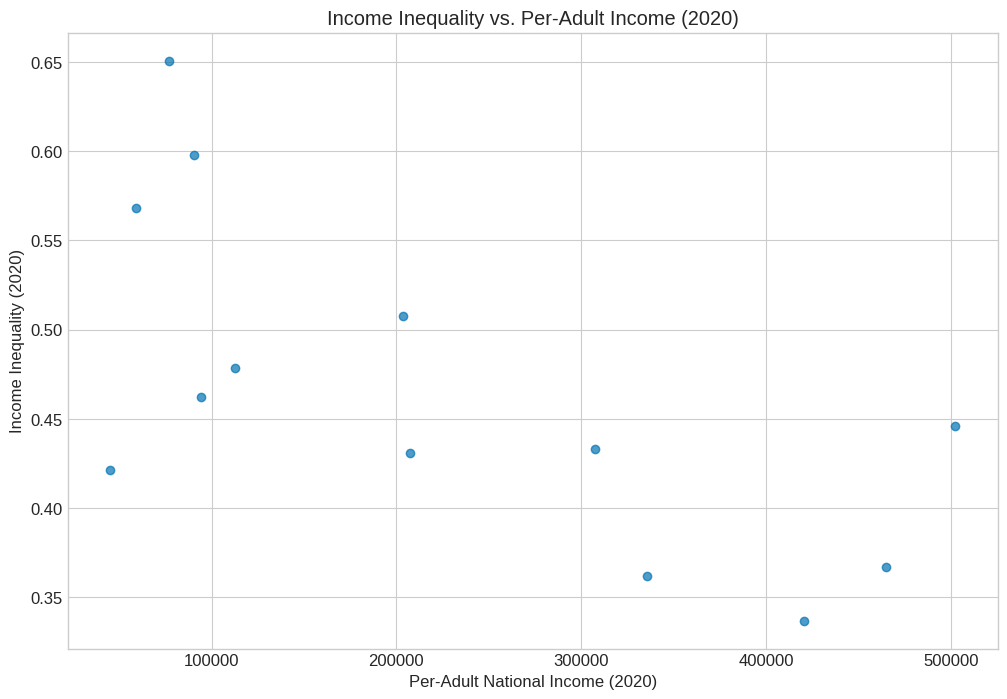

Correlation between Per-Adult Income and Income Inequality: -0.6705780393882249
                            OLS Regression Results                            
Dep. Variable:       IncomeInequality   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     8.988
Date:                Sun, 13 Apr 2025   Prob (F-statistic):             0.0121
Time:                        04:53:08   Log-Likelihood:                 16.704
No. Observations:                  13   AIC:                            -29.41
Df Residuals:                      11   BIC:                            -28.28
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

In [28]:
# Suppose you want the data for the year 2020 only
df_2020 = df_merged[df_merged['Year'] == 2020].copy()
plt.scatter(df_2020['PerAdultIncome'], df_2020['IncomeInequality'], alpha=0.7)
plt.xlabel("Per-Adult National Income (2020)")
plt.ylabel("Income Inequality (2020)")
plt.title("Income Inequality vs. Per-Adult Income (2020)")
plt.show()


# Calculate Pearson correlation
corr_h1 = df_2020['PerAdultIncome'].corr(df_2020['IncomeInequality'])
print("Correlation between Per-Adult Income and Income Inequality:", corr_h1)

# Regression model for further inspection
X = sm.add_constant(df_2020['PerAdultIncome'])
model_h1 = sm.OLS(df_2020['IncomeInequality'], X).fit()
print(model_h1.summary())

In [27]:
from linearmodels.panel import PanelOLS

# Prepare a MultiIndex DataFrame with Country and Year as indexes:
df_panel = df_merged.set_index(["Country", "Year"])

# Define the model. In this case, we assume a fixed effects model.
exog = sm.add_constant(df_panel["PerAdultIncome"])
mod = PanelOLS(df_panel["IncomeInequality"], exog, entity_effects=True)
res = mod.fit()
print(res)


                          PanelOLS Estimation Summary                           
Dep. Variable:       IncomeInequality   R-squared:                        0.1069
Estimator:                   PanelOLS   R-squared (Between):             -0.5608
No. Observations:                 377   R-squared (Within):               0.1069
Date:                Sun, Apr 13 2025   R-squared (Overall):             -0.4606
Time:                        04:50:13   Log-likelihood                    774.79
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      43.468
Entities:                          13   P-value                           0.0000
Avg Obs:                       29.000   Distribution:                   F(1,363)
Min Obs:                       29.000                                           
Max Obs:                       29.000   F-statistic (robust):             43.468
                            

In [29]:
from linearmodels.panel import PanelOLS

# Prepare the panel data: set a MultiIndex with Country and Year.
df_panel = df_merged.set_index(["Country", "Year"])

# Create the exogenous variable with a constant.
exog = sm.add_constant(df_panel["PerAdultIncome"])

# Estimate a fixed effects model (entity effects) with robust standard errors.
fe_model = PanelOLS(df_panel["IncomeInequality"], exog, entity_effects=True)
fe_results_robust = fe_model.fit(cov_type='robust')
print(fe_results_robust)


                          PanelOLS Estimation Summary                           
Dep. Variable:       IncomeInequality   R-squared:                        0.1069
Estimator:                   PanelOLS   R-squared (Between):             -0.5608
No. Observations:                 377   R-squared (Within):               0.1069
Date:                Sun, Apr 13 2025   R-squared (Overall):             -0.4606
Time:                        04:54:58   Log-likelihood                    774.79
Cov. Estimator:                Robust                                           
                                        F-statistic:                      43.468
Entities:                          13   P-value                           0.0000
Avg Obs:                       29.000   Distribution:                   F(1,363)
Min Obs:                       29.000                                           
Max Obs:                       29.000   F-statistic (robust):             117.04
                            

In [35]:
from linearmodels.panel import RandomEffects

# Estimate a random effects model
re_model = RandomEffects(df_panel["IncomeInequality"], exog)
re_results = re_model.fit()
print(re_results)


                        RandomEffects Estimation Summary                        
Dep. Variable:       IncomeInequality   R-squared:                        0.0805
Estimator:              RandomEffects   R-squared (Between):             -0.4707
No. Observations:                 377   R-squared (Within):               0.1050
Date:                Sun, Apr 13 2025   R-squared (Overall):             -0.3843
Time:                        04:56:46   Log-likelihood                    761.09
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      32.828
Entities:                          13   P-value                           0.0000
Avg Obs:                       29.000   Distribution:                   F(1,375)
Min Obs:                       29.000                                           
Max Obs:                       29.000   F-statistic (robust):             32.828
                            

In [36]:
from linearmodels.panel import compare

# Compare fixed effects (FE) and random effects (RE)
comparison = compare({'FE': fe_results_robust, 'RE': re_results})
print(comparison)


                         Model Comparison                        
                                          FE                   RE
-----------------------------------------------------------------
Dep. Variable               IncomeInequality     IncomeInequality
Estimator                           PanelOLS        RandomEffects
No. Observations                         377                  377
Cov. Est.                             Robust           Unadjusted
R-squared                             0.1069               0.0805
R-Squared (Within)                    0.1069               0.1050
R-Squared (Between)                  -0.5608              -0.4707
R-Squared (Overall)                  -0.4606              -0.3843
F-statistic                           43.468               32.828
P-value (F-stat)                      0.0000               0.0000
=====================     ==================   ==================
const                                 0.4086               0.4138
          

In [32]:
# Select data for 2020 only
df_2020 = df_merged[df_merged["Year"] == 2020].copy()

# Run an OLS regression
ols_model_2020 = sm.OLS(df_2020["IncomeInequality"], sm.add_constant(df_2020["PerAdultIncome"]))
ols_results_2020 = ols_model_2020.fit()
print(ols_results_2020.summary())


                            OLS Regression Results                            
Dep. Variable:       IncomeInequality   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     8.988
Date:                Sun, 13 Apr 2025   Prob (F-statistic):             0.0121
Time:                        04:55:26   Log-Likelihood:                 16.704
No. Observations:                  13   AIC:                            -29.41
Df Residuals:                      11   BIC:                            -28.28
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5526      0.035     15.

In [33]:
# Select data for 2020 only
df_2020 = df_merged[df_merged["Year"] == 2020].copy()

# Run an OLS regression
ols_model_2020 = sm.OLS(df_2020["IncomeInequality"], sm.add_constant(df_2020["PerAdultIncome"]))
ols_results_2020 = ols_model_2020.fit()
print(ols_results_2020.summary())


                            OLS Regression Results                            
Dep. Variable:       IncomeInequality   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     8.988
Date:                Sun, 13 Apr 2025   Prob (F-statistic):             0.0121
Time:                        04:55:32   Log-Likelihood:                 16.704
No. Observations:                  13   AIC:                            -29.41
Df Residuals:                      11   BIC:                            -28.28
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5526      0.035     15.

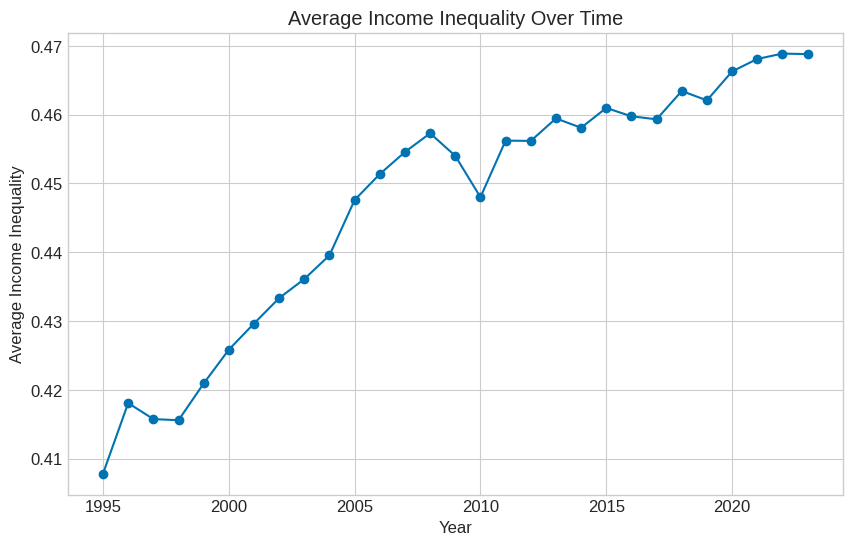

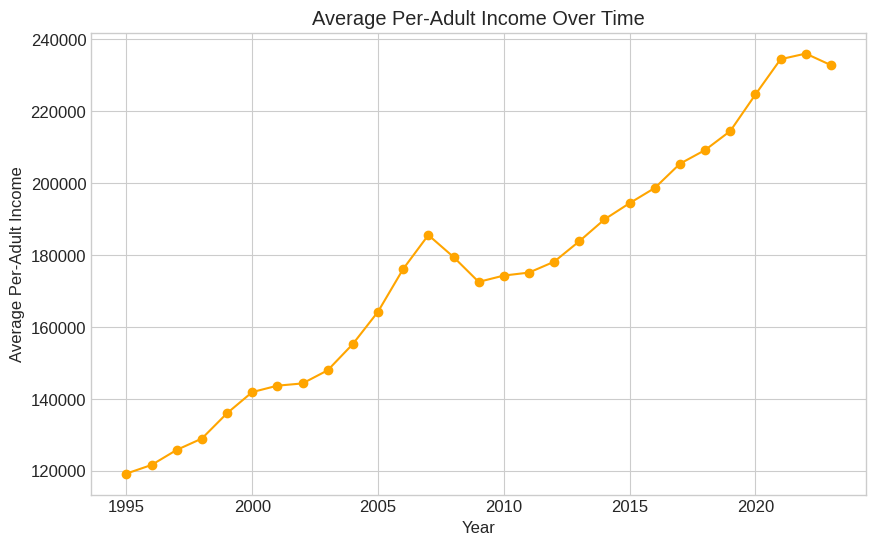

In [34]:
# Compute the average IncomeInequality per year
avg_inequality = df_merged.groupby("Year")["IncomeInequality"].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_inequality.index, avg_inequality.values, marker='o')
plt.xlabel("Year")
plt.ylabel("Average Income Inequality")
plt.title("Average Income Inequality Over Time")
plt.grid(True)
plt.show()

# Compute the average PerAdultIncome per year
avg_income = df_merged.groupby("Year")["PerAdultIncome"].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_income.index, avg_income.values, marker='o', color='orange')
plt.xlabel("Year")
plt.ylabel("Average Per-Adult Income")
plt.title("Average Per-Adult Income Over Time")
plt.grid(True)
plt.show()
